## Adaptive subtraction

In this notebook we apply adaptive subtraction to correct an initial estimate of the multiples in seismic data to complete shot gathers by using a patching operator and after that doing qc on the common channel gathers.

First, we import the required libraries

In [28]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import time
import warnings
warnings.filterwarnings('ignore')

import os
import numpy as np
import matplotlib.pyplot as plt
import segyio

# from pylops.utils.wavelets import ricker
# from pylops.utils.seismicevents import makeaxis, hyperbolic2d
# from pylops.utils import dottest
# from pylops import LinearOperator
# from pylops.signalprocessing import Radon2D
# from pylops.optimization.sparsity import FISTA
import pylops
from pylops.optimization.solver import lsqr

# some_file.py
import sys
# caution: path[0] is reserved for script path (or '' in REPL)
sys.path.insert(1, '../adasubtraction')

from ADMM import ADMM
from IRLS import IRLS
from read_gathers import read_gathers
# from pylops.optimization.leastsquares import RegularizedInversion
from adaptive_subtraction_3d import adaptive_subtraction_3d
from adaptive_subtraction_qc import adaptive_subtraction_qc

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Voring data

We will save the data into a cube to be able to retrieve common channel gathers. First, let's load some parameters as in the previous notebook.

In [29]:
# read the Saga Voring shots file

filename = '../data/Voring/shots.inter.su'

with segyio.su.open(filename, ignore_geometry=True, endian='little') as sufile:
    # map all the headers
    sufile.mmap()
    
    # Extract some headers for all traces
    fldr = sufile.attributes(segyio.su.fldr)[:] # shot number for each trace
    sx = sufile.attributes(segyio.su.sx)[:]  # source positions
    gx = sufile.attributes(segyio.su.gx)[:]  # receiver positions
    ns_all = sufile.attributes(segyio.su.ns)[:]
    ns=ns_all[0]   # number of samples 
    dtus_all = sufile.attributes(segyio.su.dt)[:]
    dtus=dtus_all[0]   
    scalco_all = sufile.attributes(segyio.su.scalco)[:]
    scalco=scalco_all[0]
    ntr=len(fldr)   # number of traces
    
    # determine from scalco scale factor for the coordinates
    scl=1.0
    if scalco <0 :
        scl=1 / abs(scalco)
    if scalco > 0:
        scl=abs(scalco)
        
    # determine dt from dtus
    dt=dtus/1000000

Now we load the total data including the primaries and multiples and store it into a cube.

In [30]:
filename = '../data/Voring/shots.inter.su'

data = read_gathers(filename)

In [31]:
data.shape

(399, 186, 2001)

In [35]:
4625*180/185

4500.0

In [ ]:
# Plotting parameters
vmax = 0.1 * np.amax(data)
vmin = -vmax
t0 = 0.0
t1 = t0 + (ns - 1) * dt
xmin = -4625
xmax = 0

idxs_src = [537, 717, 797, 857]

fig, axs = plt.subplots(1, 4, figsize=(12,8),sharey=True)
axs[0].imshow(data[10].T, aspect='auto', vmin=vmin, vmax=vmax, extent=[xmin,xmax,t1,t0], cmap='gray')
axs[0].set_title(f'Shot Gather for sx={idxs_src[0]}',fontsize=14)
axs[0].set_xlabel('Offset x (m)',fontsize=16)
axs[0].set_ylabel('Time (s)',fontsize=16)
axs[1].imshow(data[90].T, aspect='auto', vmin=vmin, vmax=vmax, extent=[xmin,xmax,t1,t0], cmap='gray')
axs[1].set_title(f'Shot Gather for sx={idxs_src[1]}',fontsize=14)
axs[1].set_xlabel('Offset x (m)',fontsize=16)
axs[2].imshow(data[170].T, aspect='auto', vmin=vmin, vmax=vmax, extent=[xmin,xmax,t1,t0], cmap='gray')
axs[2].set_title(f'Shot Gather for sx={idxs_src[2]}',fontsize=14)
axs[2].set_xlabel('Offset x (m)',fontsize=16)
axs[3].imshow(data[230].T, aspect='auto', vmin=vmin, vmax=vmax, extent=[xmin,xmax,t1,t0], cmap='gray')
axs[3].set_title(f'Shot Gather for sx={idxs_src[3]}',fontsize=14)
axs[3].set_xlabel('Offset x (m)',fontsize=16)
plt.tight_layout()

In [ ]:
idxs_rec = [10, 50, 100, 140]

fig, axs = plt.subplots(1, 4, figsize=(12,8),sharey=True)
axs[0].imshow(data[:,10].T, aspect='auto', vmin=vmin, vmax=vmax, extent=[xmin,xmax,t1,t0], cmap='gray')
axs[0].set_title(f'Channel Gather for rx={idxs_rec[0]}',fontsize=14)
axs[0].set_xlabel('Offset x (m)',fontsize=16)
axs[0].set_ylabel('Time (s)',fontsize=16)
axs[1].imshow(data[:,50].T, aspect='auto', vmin=vmin, vmax=vmax, extent=[xmin,xmax,t1,t0], cmap='gray')
axs[1].set_title(f'Channel Gather for rx={idxs_rec[1]}',fontsize=14)
axs[1].set_xlabel('Offset x (m)',fontsize=16)
axs[2].imshow(data[:,100].T, aspect='auto', vmin=vmin, vmax=vmax, extent=[xmin,xmax,t1,t0], cmap='gray')
axs[2].set_title(f'Channel Gather for rx={idxs_rec[2]}',fontsize=14)
axs[2].set_xlabel('Offset x (m)',fontsize=16)
axs[3].imshow(data[:,140].T, aspect='auto', vmin=vmin, vmax=vmax, extent=[xmin,xmax,t1,t0], cmap='gray')
axs[3].set_title(f'Channel Gather for rx={idxs_rec[3]}',fontsize=14)
axs[3].set_xlabel('Offset x (m)',fontsize=16)
plt.tight_layout()

And here we load an initial estimate of the multiples that needs to be corrected via adaptive subtraction.

In [18]:
filename = '../data/Voring/shots.multwav.su'

multiples = read_gathers(filename)

In [ ]:
vmax = 0.02 * np.amax(data)
vmin = -vmax

fig, axs = plt.subplots(1, 4, figsize=(12,8),sharey=True)
axs[0].imshow(multiples[10].T, aspect='auto', vmin=vmin, vmax=vmax, extent=[xmin,xmax,t1,t0], cmap='gray')
axs[0].set_title(f'Estimated Multiples for sx={idxs_src[0]}',fontsize=12)
axs[0].set_xlabel('Offset x (m)',fontsize=16)
axs[0].set_ylabel('Time (s)',fontsize=16)
axs[1].imshow(multiples[90].T, aspect='auto', vmin=vmin, vmax=vmax, extent=[xmin,xmax,t1,t0], cmap='gray')
axs[1].set_title(f'Estimated Multiples for sx={idxs_src[1]}',fontsize=12)
axs[1].set_xlabel('Offset x (m)',fontsize=16)
axs[2].imshow(multiples[170].T, aspect='auto', vmin=vmin, vmax=vmax, extent=[xmin,xmax,t1,t0], cmap='gray')
axs[2].set_title(f'Estimated Multiples for sx={idxs_src[2]}',fontsize=12)
axs[2].set_xlabel('Offset x (m)',fontsize=16)
axs[3].imshow(multiples[230].T, aspect='auto', vmin=vmin, vmax=vmax, extent=[xmin,xmax,t1,t0], cmap='gray')
axs[3].set_title(f'Estimated Multiples for sx={idxs_src[3]}',fontsize=12)
axs[3].set_xlabel('Offset x (m)',fontsize=16)
plt.tight_layout()

In [ ]:
fig, axs = plt.subplots(1, 4, figsize=(12,8),sharey=True)
axs[0].imshow(multiples[:,10].T, aspect='auto', vmin=vmin, vmax=vmax, extent=[xmin,xmax,t1,t0], cmap='gray')
axs[0].set_title(f'Estimated Multiples for rx={idxs_rec[0]}',fontsize=12)
axs[0].set_xlabel('Offset x (m)',fontsize=16)
axs[0].set_ylabel('Time (s)',fontsize=16)
axs[1].imshow(multiples[:,50].T, aspect='auto', vmin=vmin, vmax=vmax, extent=[xmin,xmax,t1,t0], cmap='gray')
axs[1].set_title(f'Estimated Multiples for rx={idxs_rec[1]}',fontsize=12)
axs[1].set_xlabel('Offset x (m)',fontsize=16)
axs[2].imshow(multiples[:,100].T, aspect='auto', vmin=vmin, vmax=vmax, extent=[xmin,xmax,t1,t0], cmap='gray')
axs[2].set_title(f'Estimated Multiples for rx={idxs_rec[2]}',fontsize=12)
axs[2].set_xlabel('Offset x (m)',fontsize=16)
axs[3].imshow(multiples[:,140].T, aspect='auto', vmin=vmin, vmax=vmax, extent=[xmin,xmax,t1,t0], cmap='gray')
axs[3].set_title(f'Estimated Multiples for rx={idxs_rec[3]}',fontsize=12)
axs[3].set_xlabel('Offset x (m)',fontsize=16)
plt.tight_layout()

The following data is an estimate of the primaries and multiples using the $L_2$-norm (SRME).

In [19]:
filename = '../data/Voring/shots.srme.su'

srme = read_gathers(filename)

In [ ]:
vmax = 0.1 * np.amax(data)
vmin = -vmax

fig, axs = plt.subplots(1, 4, figsize=(12,8),sharey=True)
axs[0].imshow(srme[10].T, aspect='auto', vmin=vmin, vmax=vmax, extent=[xmin,xmax,t1,t0], cmap='gray')
axs[0].set_title(f'SRME Primaries for sx={idxs_src[0]}',fontsize=12)
axs[0].set_xlabel('Offset x (m)',fontsize=16)
axs[0].set_ylabel('Time (s)',fontsize=16)
axs[1].imshow(srme[90].T, aspect='auto', vmin=vmin, vmax=vmax, extent=[xmin,xmax,t1,t0], cmap='gray')
axs[1].set_title(f'SRME Primaries for sx={idxs_src[1]}',fontsize=12)
axs[1].set_xlabel('Offset x (m)',fontsize=16)
axs[2].imshow(srme[170].T, aspect='auto', vmin=vmin, vmax=vmax, extent=[xmin,xmax,t1,t0], cmap='gray')
axs[2].set_title(f'SRME Primaries for sx={idxs_src[2]}',fontsize=12)
axs[2].set_xlabel('Offset x (m)',fontsize=16)
axs[3].imshow(srme[230].T, aspect='auto', vmin=vmin, vmax=vmax, extent=[xmin,xmax,t1,t0], cmap='gray')
axs[3].set_title(f'SRME Primaries for sx={idxs_src[3]}',fontsize=12)
axs[3].set_xlabel('Offset x (m)',fontsize=16)
plt.tight_layout()

In [ ]:
fig, axs = plt.subplots(1, 4, figsize=(12,8),sharey=True)
axs[0].imshow(srme[:,10].T, aspect='auto', vmin=vmin, vmax=vmax, extent=[xmin,xmax,t1,t0], cmap='gray')
axs[0].set_title(f'SRME Primaries for rx={idxs_rec[0]}',fontsize=12)
axs[0].set_xlabel('Offset x (m)',fontsize=16)
axs[0].set_ylabel('Time (s)',fontsize=16)
axs[1].imshow(srme[:,50].T, aspect='auto', vmin=vmin, vmax=vmax, extent=[xmin,xmax,t1,t0], cmap='gray')
axs[1].set_title(f'SRME Primaries for rx={idxs_rec[1]}',fontsize=12)
axs[1].set_xlabel('Offset x (m)',fontsize=16)
axs[2].imshow(srme[:,100].T, aspect='auto', vmin=vmin, vmax=vmax, extent=[xmin,xmax,t1,t0], cmap='gray')
axs[2].set_title(f'SRME Primaries for rx={idxs_rec[2]}',fontsize=12)
axs[2].set_xlabel('Offset x (m)',fontsize=16)
axs[3].imshow(srme[:,140].T, aspect='auto', vmin=vmin, vmax=vmax, extent=[xmin,xmax,t1,t0], cmap='gray')
axs[3].set_title(f'SRME Primaries for rx={idxs_rec[3]}',fontsize=12)
axs[3].set_xlabel('Offset x (m)',fontsize=16)
plt.tight_layout()

We now select one common shot gather to apply adaptive subtraction to: shot 800.

In [11]:
# Index = 800-627-1 = 172
shot_800 = data[172]
multiples_800 = multiples[172]
srme_800 = srme[172]

In [ ]:
# plot the selected shot
vmax = 0.05 * np.amax(data)
vmin = -vmax

fig, axs = plt.subplots(1, 4, figsize=(12,8),sharey=True)
axs[0].imshow(shot_800.T, aspect='auto', vmin=vmin, vmax=vmax, extent=[xmin,xmax,t1,t0], cmap='gray')
axs[0].set_title('Data for Shot 800',fontsize=14)
axs[0].set_xlabel('Offset x (m)',fontsize=16)
axs[0].set_ylabel('Time (s)',fontsize=16)
axs[1].imshow(multiples_800.T, aspect='auto', vmin=vmin, vmax=vmax, extent=[xmin,xmax,t1,t0], cmap='gray')
axs[1].set_title('Estimated multiples',fontsize=14)
axs[1].set_xlabel('Offset x (m)',fontsize=16)
axs[2].imshow(srme_800.T, aspect='auto', vmin=vmin, vmax=vmax, extent=[xmin,xmax,t1,t0], cmap='gray')
axs[2].set_title('SRME estimated primaries',fontsize=14)
axs[2].set_xlabel('Offset x (m)',fontsize=16)
axs[3].imshow((shot_800 - srme_800).T, aspect='auto', vmin=vmin, vmax=vmax, extent=[xmin,xmax,t1,t0], cmap='gray')
axs[3].set_title('SRME estimated multiples',fontsize=14)
axs[3].set_xlabel('Offset x (m)',fontsize=16)
plt.tight_layout()

We now apply the ADMM algorithm to the Voring dataset. For field data adaptive subtraction is done in patches, where every patch corresponds to one filter. We start by looking at the result for 1 patch first and then move on to the entire shot gather.

In [21]:
# reshape data to then patch
nr, nt = 180, 1950

shot_800 = shot_800[:nr, :nt]
multiples_800 = multiples_800[:nr, :nt]
srme_800 = srme_800[:nr, :nt]

# set the filter size
nfilt =  11

# Create patching operator
dimsd = (nr, nt)  #shape of 2-dimensional data
nwin = (30, 150)  #number of samples of window
nover = (15, 75)  #number of samples of overlapping part of window
nop = nwin        #size of model in the transformed domain
nwins = (nr // (nwin[0]//2) - 1, nt // (nwin[1]//2) - 1)
dims = (nwins[0]*nop[0],   #shape of 2-dimensional model
        nwins[1]*nop[1])
I = pylops.Identity(nwin[0]*nwin[1])

# Get the patching operators
PatchOpH = pylops.signalprocessing.Patch2D(I, dims, dimsd, nwin, nover, nop, tapertype='none', design=False)
PatchOp  = pylops.signalprocessing.Patch2D(I, dims, dimsd, nwin, nover, nop, tapertype='hanning', design=False)

# Patch the data
data_patched = PatchOpH.H * shot_800.ravel()
multiples_patched = PatchOpH.H * multiples_800.ravel()

Let's check whether the patching operators are correct

In [ ]:
data_back = PatchOp * data_patched
data_back = data_back.reshape(shot_800.shape)
np.linalg.norm(shot_800 - data_back)

We now reorder the data to have easy access to the patches.

In [25]:
# Reorder the data so that every row is a single patch
num_patches = nwins[0] * nwins[1]
data_patched = np.reshape(data_patched, (num_patches, nwin[0]*nwin[1]))
multiples_patched = np.reshape(multiples_patched, (num_patches, nwin[0]*nwin[1]))

Plot the patches.

In [ ]:
fig, axs = plt.subplots(17, 16, figsize=(16, 16), sharey=True, sharex=True)
axs = axs.ravel()

for i in range(int(17*16)):
    data_patch_i = np.reshape(data_patched[i, :], (nwin[0], nwin[1]))
    axs[i].imshow(data_patch_i.T, aspect='auto', cmap='gray')
    axs[i].axis('off');
    plt.tight_layout();

Below we do adaptive subtraction for every patch with an $L_2$-norm on the data.

In [26]:
# Create an array to store filters
filters = np.zeros((num_patches, nfilt))
primary_est = np.zeros_like(data_patched)
multiple_est = np.zeros_like(multiples_patched)

for i in range(num_patches):
    data_patch_i = np.reshape(data_patched[i], (nwin[0], nwin[1]))
    multiple_patch_i = np.reshape(multiples_patched[i], (nwin[0], nwin[1]))
    CopStack = []
    # construct the convolutional operator
    for j in range(nwin[0]):
        C = pylops.utils.signalprocessing.convmtx(multiple_patch_i[j], nfilt)
        Cop = pylops.basicoperators.MatrixMult(C[nfilt//2:-(nfilt//2)])
        CopStack.append(Cop)
    dataStack = data_patch_i.ravel()
    CopStack  = pylops.VStack(CopStack)
    # solve for the filter
    filt_est = lsqr(CopStack, dataStack, x0=np.zeros(nfilt), niter=15)[0]
    filters[i] = filt_est
    multiple_est[i] = (CopStack * filt_est).T 
    primary_est[i]  = (dataStack - multiple_est[i].T).T

# Glue the patches back together
primary_est = PatchOp * primary_est.ravel()
multiple_est = PatchOp * multiple_est.ravel()
primary_est = np.reshape(primary_est, (nr, nt))
multiple_est = np.reshape(multiple_est, (nr, nt))

In [ ]:
# Without clipping
e1 = np.linalg.norm(multiple_est-(shot_800 - srme_800))/np.linalg.norm((shot_800 - srme_800))
print(e1)

In [ ]:
# Plot data if filter "blows up", meaning exceeds 10
from mpl_toolkits.axes_grid1 import make_axes_locatable

print("Number of filters: ", filters.shape[0])
print("Number of filters that exceed 10: ", np.count_nonzero([max(abs(f))>10 for f in filters]))

for i in range(filters.shape[0]):

    if max(abs(filters[i]))>10:
        
        data_patch_i = np.reshape(data_patched[i, :], (nwin[0], nwin[1]))
        
        fig, axs = plt.subplots(2, 1, figsize=(3, 6))
        axs[0].plot(filters[i])
        axs[0].set_title(f'Estimated filter patch {i}', fontsize=10)
        im = axs[1].imshow(data_patch_i.T, aspect='auto', cmap='gray')
        axs[1].set_title(f'Total data patch {i}', fontsize=9)
        
        divider = make_axes_locatable(axs[1])
        cax = divider.append_axes('right', size='5%', pad=0.05)
        fig.colorbar(im, cax=cax, orientation='vertical')
        
        plt.show()
        plt.tight_layout()

Plot the results and compare to the SRME results.

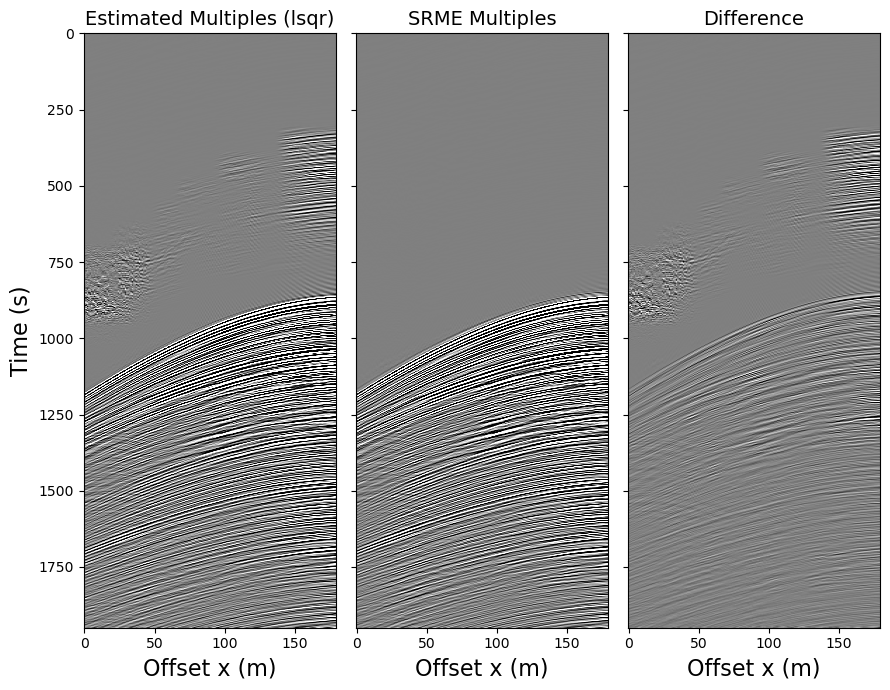

In [27]:
# Plot difference with respect to SRME multiples
vmax = 0.005*np.amax(data)
vmin = -vmax
xmin = -4625
xmax = 0
t0 = 0.0
t1 = t0 + (ns - 1) * dt

srme_multiples = shot_800 - srme_800

fig, axs = plt.subplots(1, 3, figsize=(9,7),sharey=True)
axs[0].imshow(multiple_est.T, aspect='auto', vmin=vmin, vmax=vmax, cmap='gray')
axs[0].set_title('Estimated Multiples (lsqr)',fontsize=14)
axs[0].set_xlabel('Offset x (m)',fontsize=16)
axs[0].set_ylabel('Time (s)',fontsize=16)
axs[1].imshow(srme_multiples.T, aspect='auto', vmin=vmin, vmax=vmax, cmap='gray')
axs[1].set_title('SRME Multiples',fontsize=14)
axs[1].set_xlabel('Offset x (m)',fontsize=16)
axs[2].imshow((srme_multiples-multiple_est).T, aspect='auto', vmin=vmin, vmax=vmax, cmap='gray')
axs[2].set_title('Difference',fontsize=14)
axs[2].set_xlabel('Offset x (m)',fontsize=16)

plt.tight_layout()

Now let's clip blowing filters setting them to 1.

In [ ]:
primary_est = np.zeros_like(data_patched)
multiple_est = np.zeros_like(multiples_patched)
# Create an array to store filters
filters = np.zeros((num_patches, nfilt))

for i in range(num_patches):
    data_patch_i = np.reshape(data_patched[i], (nwin[0], nwin[1]))
    multiple_patch_i = np.reshape(multiples_patched[i], (nwin[0], nwin[1]))
    CopStack = []
    # construct the convolutional operator
    for j in range(nwin[0]):
        C = pylops.utils.signalprocessing.convmtx(multiple_patch_i[j], nfilt)
        Cop = pylops.basicoperators.MatrixMult(C[nfilt//2:-(nfilt//2)])
        CopStack.append(Cop)
    dataStack = data_patch_i.ravel()
    CopStack  = pylops.VStack(CopStack)
    # solve for the filter
    filt_est = lsqr(CopStack, dataStack, x0=np.zeros(nfilt), niter=10, damp=0)[0]
    # clipping
    if max(abs(filt_est)) > 10:
        filt_est = np.ones(nfilt)
    multiple_est[i] = (CopStack * filt_est).T # Make sure it's in (nr, nt) format before patching back! 
    primary_est[i]  = (dataStack - multiple_est[i].T).T

# Glue the patches back together
primary_est = PatchOp * primary_est.ravel()
multiple_est = PatchOp * multiple_est.ravel()
primary_est = np.reshape(primary_est, (nr, nt))
multiple_est = np.reshape(multiple_est, (nr, nt))

In [ ]:
# With clipping
e2 = np.linalg.norm(multiple_est-srme_multiples)/np.linalg.norm(srme_multiples)
print(e2)

In [ ]:
# Improvement with clipping
print('The clipping of filters reduced the multiple adaptive subtraction error'
      ' with respect to SRME in a',"%.2f"%((e1-e2)*100), '%')

In [ ]:
# Plot difference of clipped adaptive subtraction with respect to SRME multiples
fig, axs = plt.subplots(1, 3, figsize=(9,7),sharey=True)
axs[0].imshow(multiple_est.T, aspect='auto', vmin=vmin, vmax=vmax, cmap='gray')
axs[0].set_title('Estimated Multiples (lsqr)',fontsize=14)
axs[0].set_xlabel('Offset x (m)',fontsize=16)
axs[0].set_ylabel('Time (s)',fontsize=16)
axs[1].imshow(srme_multiples.T, aspect='auto', vmin=vmin, vmax=vmax, cmap='gray')
axs[1].set_title('SRME Multiples',fontsize=14)
axs[1].set_xlabel('Offset x (m)',fontsize=16)
axs[2].imshow((srme_multiples-multiple_est).T, aspect='auto', vmin=vmin, vmax=vmax, cmap='gray')
axs[2].set_title('Difference',fontsize=14)
axs[2].set_xlabel('Offset x (m)',fontsize=16)

plt.tight_layout()

Let's pick a trace and compare the results of the lsqr with SRME more in detail.

In [ ]:
t_plot = np.linspace(0,8,1950)

fig, axs = plt.subplots(1, 1, figsize=(7,7),sharey=True)
axs.plot(multiple_est[170], t_plot, label='$L_2$')
axs.plot(srme_multiples[170], t_plot, label='SRME')
axs.set_ylim([8, 0])

plt.legend()
plt.tight_layout()

In [ ]:
fig, axs = plt.subplots(1, 1, figsize=(7,7),sharey=True)
axs.plot(multiple_est[100], t_plot, label='$L_2$')
axs.plot(srme_multiples[100], t_plot, label='SRME')
axs.set_ylim([4, 3])

plt.legend()
plt.tight_layout()

The code above is wrapped in the adaptive_subtraction_3d function, which applies it for the whole gather cube. Let's load the data

In [ ]:
# prim_cube, mult_cube = adaptive_subtraction_3d(data, multiples, nfilt=11, solver='lsqr',
#                                                  solver_dict={'x0':np.zeros(nfilt),
#                                                               'niter':10, 
#                                                               'damp':0})
# np.savez('Data/lsqr.npz', prim_cube, mult_cube)

In [ ]:
prim_cube = np.load('Data/lsqr.npz')['arr_0']
mult_cube = np.load('Data/lsqr.npz')['arr_1']

Let's check if the multiples corrected for shot 800 for the whole cube is the same as the estimated above.

In [ ]:
np.linalg.norm(multiple_est - mult_cube[172])

Now we visualize some of the primaries and multiples corrected via adaptive subtraction with the lsqr.

In [ ]:
# Plotting parameters
vmax = 0.05 * np.amax(data)
vmin = -vmax
t0 = 0.0
t1 = t0 + (ns - 1) * dt
xmin = -4625
xmax = 0

fig, axs = plt.subplots(1, 4, figsize=(12,8),sharey=True)
axs[0].imshow(prim_cube[10].T, aspect='auto', vmin=vmin, vmax=vmax, extent=[xmin,xmax,t1,t0], cmap='gray')
axs[0].set_title(f'Primaries (lsqr) for sx={627+10}',fontsize=14)
axs[0].set_xlabel('Offset x (m)',fontsize=16)
axs[0].set_ylabel('Time (s)',fontsize=16)
axs[1].imshow(prim_cube[90].T, aspect='auto', vmin=vmin, vmax=vmax, extent=[xmin,xmax,t1,t0], cmap='gray')
axs[1].set_title(f'Primaries (lsqr) for sx={627+90}',fontsize=14)
axs[1].set_xlabel('Offset x (m)',fontsize=16)
axs[2].imshow(prim_cube[170].T, aspect='auto', vmin=vmin, vmax=vmax, extent=[xmin,xmax,t1,t0], cmap='gray')
axs[2].set_title(f'Primaries (lsqr) for sx={627+170}',fontsize=14)
axs[2].set_xlabel('Offset x (m)',fontsize=16)
axs[3].imshow(prim_cube[230].T, aspect='auto', vmin=vmin, vmax=vmax, extent=[xmin,xmax,t1,t0], cmap='gray')
axs[3].set_title(f'Primaries (lsqr) for sx={627+230}',fontsize=14)
axs[3].set_xlabel('Offset x (m)',fontsize=16)
plt.tight_layout()

In [ ]:
fig, axs = plt.subplots(1, 4, figsize=(12,8),sharey=True)
axs[0].imshow(prim_cube[:,10].T, aspect='auto', vmin=vmin, vmax=vmax, extent=[xmin,xmax,t1,t0], cmap='gray')
axs[0].set_title(f'Primaries (lsqr) for rx={10}',fontsize=14)
axs[0].set_xlabel('Offset x (m)',fontsize=16)
axs[0].set_ylabel('Time (s)',fontsize=16)
axs[1].imshow(prim_cube[:,50].T, aspect='auto', vmin=vmin, vmax=vmax, extent=[xmin,xmax,t1,t0], cmap='gray')
axs[1].set_title(f'Primaries (lsqr) for rx={50}',fontsize=14)
axs[1].set_xlabel('Offset x (m)',fontsize=16)
axs[2].imshow(prim_cube[:,100].T, aspect='auto', vmin=vmin, vmax=vmax, extent=[xmin,xmax,t1,t0], cmap='gray')
axs[2].set_title(f'Primaries (lsqr) for rx={100}',fontsize=14)
axs[2].set_xlabel('Offset x (m)',fontsize=16)
axs[3].imshow(prim_cube[:,140].T, aspect='auto', vmin=vmin, vmax=vmax, extent=[xmin,xmax,t1,t0], cmap='gray')
axs[3].set_title(f'Primaries (lsqr) for rx={140}',fontsize=14)
axs[3].set_xlabel('Offset x (m)',fontsize=16)
plt.tight_layout()

In [ ]:
vmax = 0.01 * np.amax(data)
vmin = -vmax

fig, axs = plt.subplots(1, 4, figsize=(12,8),sharey=True)
axs[0].imshow(mult_cube[10].T, aspect='auto', vmin=vmin, vmax=vmax, extent=[xmin,xmax,t1,t0], cmap='gray')
axs[0].set_title(f'Multiples (lsqr) for sx={627+10}',fontsize=14)
axs[0].set_xlabel('Offset x (m)',fontsize=16)
axs[0].set_ylabel('Time (s)',fontsize=16)
axs[1].imshow(mult_cube[90].T, aspect='auto', vmin=vmin, vmax=vmax, extent=[xmin,xmax,t1,t0], cmap='gray')
axs[1].set_title(f'Multiples (lsqr) for sx={627+90}',fontsize=14)
axs[1].set_xlabel('Offset x (m)',fontsize=16)
axs[2].imshow(mult_cube[170].T, aspect='auto', vmin=vmin, vmax=vmax, extent=[xmin,xmax,t1,t0], cmap='gray')
axs[2].set_title(f'Multiples (lsqr) for sx={627+170}',fontsize=14)
axs[2].set_xlabel('Offset x (m)',fontsize=16)
axs[3].imshow(mult_cube[230].T, aspect='auto', vmin=vmin, vmax=vmax, extent=[xmin,xmax,t1,t0], cmap='gray')
axs[3].set_title(f'Multiples (lsqr) for sx={627+230}',fontsize=14)
axs[3].set_xlabel('Offset x (m)',fontsize=16)
plt.tight_layout()

In [ ]:
fig, axs = plt.subplots(1, 4, figsize=(12,8),sharey=True)
axs[0].imshow(mult_cube[:,10,:].T, aspect='auto', vmin=vmin, vmax=vmax, extent=[xmin,xmax,t1,t0], cmap='gray')
axs[0].set_title(f'Multiples (lsqr) for rx={10}',fontsize=14)
axs[0].set_xlabel('Offset x (m)',fontsize=16)
axs[0].set_ylabel('Time (s)',fontsize=16)
axs[1].imshow(mult_cube[:,50,:].T, aspect='auto', vmin=vmin, vmax=vmax, extent=[xmin,xmax,t1,t0], cmap='gray')
axs[1].set_title(f'Multiples (lsqr) for rx={50}',fontsize=14)
axs[1].set_xlabel('Offset x (m)',fontsize=16)
axs[2].imshow(mult_cube[:,100,:].T, aspect='auto', vmin=vmin, vmax=vmax, extent=[xmin,xmax,t1,t0], cmap='gray')
axs[2].set_title(f'Multiples (lsqr) for rx={100}',fontsize=14)
axs[2].set_xlabel('Offset x (m)',fontsize=16)
axs[3].imshow(mult_cube[:,140,:].T, aspect='auto', vmin=vmin, vmax=vmax, extent=[xmin,xmax,t1,t0], cmap='gray')
axs[3].set_title(f'Multiples (lsqr) for rx={140}',fontsize=14)
axs[3].set_xlabel('Offset x (m)',fontsize=16)
plt.tight_layout()

Below we do quality control comparing the autocorrelation of traces of the total data with respect to the primaries.

We choose the common channel gather and estimated primaries for the receiver 150 as example

In [ ]:
vmax = 0.03 * np.amax(data)
vmin = -vmax

gather_num = 150

fig, axs = plt.subplots(1, 2, figsize=(10,8),sharey=True)
axs[0].imshow(data[:,gather_num-1,:].T, aspect='auto', vmin=vmin, vmax=vmax, extent=[xmin,xmax,t1,t0], cmap='gray')
axs[0].set_title(f'CCG for rx={gather_num}',fontsize=14)
axs[0].set_xlabel('Offset x (m)',fontsize=14)
axs[0].set_ylabel('Time (s)',fontsize=14)
axs[1].imshow(prim_cube[:,gather_num-1,:].T, aspect='auto', vmin=vmin, vmax=vmax, extent=[xmin,xmax,t1,t0], cmap='gray')
axs[1].set_title(f'Primaries (lsqr) for rx={gather_num}',fontsize=14)
axs[1].set_xlabel('Offset x (m)',fontsize=14)

In [ ]:
mult_avg, prim_avg = adaptive_subtraction_qc(data, prim_cube, mult_cube, gather_num)
print("Average amplitud of the first multiple in total data:", mult_avg)
print("Average amplitud of the first multiple in primaries:", prim_avg)

Let's now do some tests on the ADMM. First only on one shot

In [ ]:
start_time = time.time()/60
primary_l1 = np.zeros_like(data_patched)
multiple_l1 = np.zeros_like(multiples_patched)

for i in range(num_patches):
    if i%20 == 0:
        print(i)
    data_patch_i = np.reshape(data_patched[i], (nwin[0], nwin[1]))
    multiple_patch_i = np.reshape(multiples_patched[i], (nwin[0], nwin[1]))
    CopStack = []
    # construct the convolutional operator
    for j in range(nwin[0]):
        C = pylops.utils.signalprocessing.convmtx(multiple_patch_i[j], nfilt)
        Cop = pylops.basicoperators.MatrixMult(C[nfilt//2:-(nfilt//2)])
        CopStack.append(Cop)
    dataStack = data_patch_i.ravel()
    CopStack  = pylops.VStack(CopStack)
    # solve for the filter
    filt_l1 = ADMM(CopStack, dataStack, rho=1e0, nouter=2000, ninner=5, eps=0e0)  #originally outer_its, inner_its
    multiple_l1[i] = (CopStack * filt_l1).T # Make sure it's in (nr, nt) format before patching back! 
    primary_l1[i]  = (dataStack - multiple_l1[i].T).T 
# Glue the patches back together
primary_l1 = PatchOp * primary_l1.ravel()
multiple_l1 = PatchOp * multiple_l1.ravel()
primary_l1 = np.reshape(primary_l1, (nr, nt))
multiple_l1 = np.reshape(multiple_l1, (nr, nt))

print("--- %s minutes ---" % (time.time()/60 - start_time))

In [ ]:
np.linalg.norm(srme_multiples-multiple_l1)/np.linalg.norm(srme_multiples)

In [ ]:
# Plot difference with respect to SRME multiples
vmax = 0.005*np.amax(data)
vmin = -vmax
xmin = -4625
xmax = 0
t0 = 0.0
t1 = t0 + (ns - 1) * dt

fig, axs = plt.subplots(1, 3, figsize=(9,7),sharey=True)
axs[0].imshow(multiple_l1.T, aspect='auto', vmin=vmin, vmax=vmax, cmap='gray')
axs[0].set_title('Estimated Multiples (ADMM)',fontsize=14)
axs[0].set_xlabel('Offset x (m)',fontsize=16)
axs[0].set_ylabel('Time (s)',fontsize=16)
axs[1].imshow(srme_multiples.T, aspect='auto', vmin=vmin, vmax=vmax, cmap='gray')
axs[1].set_title('SRME Multiples',fontsize=14)
axs[1].set_xlabel('Offset x (m)',fontsize=16)
axs[2].imshow((srme_multiples-multiple_l1).T, aspect='auto', vmin=vmin, vmax=vmax, cmap='gray')
axs[2].set_title('Difference',fontsize=14)
axs[2].set_xlabel('Offset x (m)',fontsize=16)

plt.tight_layout()

Clip blowing filters and compare results

In [ ]:
primary_l1 = np.zeros_like(data_patched)
multiple_l1 = np.zeros_like(multiples_patched)

for i in range(num_patches):
    if i%20 == 0:
        print(i)
    data_patch_i = np.reshape(data_patched[i], (nwin[0], nwin[1]))
    multiple_patch_i = np.reshape(multiples_patched[i], (nwin[0], nwin[1]))
    CopStack = []
    # construct the convolutional operator
    for j in range(nwin[0]):
        C = pylops.utils.signalprocessing.convmtx(multiple_patch_i[j], nfilt)
        Cop = pylops.basicoperators.MatrixMult(C[nfilt//2:-(nfilt//2)])
        CopStack.append(Cop)
    dataStack = data_patch_i.ravel()
    CopStack  = pylops.VStack(CopStack)
    # solve for the filter
    filt_l1 = ADMM(CopStack, dataStack, rho=1e0, nouter=2000, ninner=5, eps=0e0)  #originally outer_its, inner_its
    if max(abs(filt_est)) > 10:
        filt_est = np.ones(nfilt)
    multiple_l1[i] = (CopStack * filt_l1).T # Make sure it's in (nr, nt) format before patching back! 
    primary_l1[i]  = (dataStack - multiple_l1[i].T).T 
# Glue the patches back together
primary_l1 = PatchOp * primary_l1.ravel()
multiple_l1 = PatchOp * multiple_l1.ravel()
primary_l1 = np.reshape(primary_l1, (nr, nt))
multiple_l1 = np.reshape(multiple_l1, (nr, nt))

In [ ]:
np.linalg.norm(srme_multiples-multiple_l1)/np.linalg.norm(srme_multiples)

Clipping the filters to 1 with the ADMM resulted in a difference of 1.02e-07.

In [ ]:
# Plot difference with respect to SRME multiples
vmax = 0.005*np.amax(data)
vmin = -vmax
xmin = -4625
xmax = 0
t0 = 0.0
t1 = t0 + (ns - 1) * dt

fig, axs = plt.subplots(1, 3, figsize=(9,7),sharey=True)
axs[0].imshow(multiple_l1.T, aspect='auto', vmin=vmin, vmax=vmax, cmap='gray')
axs[0].set_title('Estimated Multiples (ADMM)',fontsize=12)
axs[0].set_xlabel('Offset x (m)',fontsize=12)
axs[0].set_ylabel('Time (s)',fontsize=12)
axs[1].imshow(srme_multiples.T, aspect='auto', vmin=vmin, vmax=vmax, cmap='gray')
axs[1].set_title('SRME Multiples',fontsize=12)
axs[1].set_xlabel('Offset x (m)',fontsize=12)
axs[2].imshow((srme_multiples-multiple_l1).T, aspect='auto', vmin=vmin, vmax=vmax, cmap='gray')
axs[2].set_title('Difference',fontsize=12)
axs[2].set_xlabel('Offset x (m)',fontsize=12)

plt.tight_layout()

# Below is all junk ignore it

In [ ]:
vmax = 0.01*np.amax(data)
vmin = -vmax


fig, ax = plt.subplots(1, 1, figsize=(15,12),sharey=True)
ax.imshow(multiple_est.T[750:], aspect='auto', vmin=vmin, vmax=vmax, cmap='gray')
ax.set_title('Estimated multiples',fontsize=14)
ax.set_xlabel('Offset x (m)',fontsize=16)

fig, ax = plt.subplots(1, 1, figsize=(15,12),sharey=True)
ax.imshow((data - srme).T[750:], aspect='auto', vmin=vmin, vmax=vmax, cmap='gray')
ax.set_title('SRME multiples',fontsize=14)
ax.set_xlabel('Offset x (m)',fontsize=16);

In [ ]:
vmax = 0.05*np.amax(data)
vmin = -vmax

fig, ax = plt.subplots(1, 1, figsize=(15,12),sharey=True)
ax.imshow(data.T[750:], aspect='auto', vmin=vmin, vmax=vmax, cmap='gray')
ax.set_title('Data',fontsize=14)
ax.set_xlabel('Offset x (m)',fontsize=16)

fig, ax = plt.subplots(1, 1, figsize=(15,12),sharey=True)
ax.imshow(multiples.T[750:], aspect='auto', vmin=vmin, vmax=vmax, cmap='gray')
ax.set_title('Estimated multiples L1',fontsize=14)
ax.set_xlabel('Offset x (m)',fontsize=16)

fig, ax = plt.subplots(1, 1, figsize=(15,12),sharey=True)
ax.imshow(primary_l1.T[750:], aspect='auto', vmin=vmin, vmax=vmax, cmap='gray')
ax.set_title('Estimated primary L1',fontsize=14)
ax.set_xlabel('Offset x (m)',fontsize=16)

fig, ax = plt.subplots(1, 1, figsize=(15,12),sharey=True)
ax.imshow(srme.T[750:], aspect='auto', vmin=vmin, vmax=vmax, cmap='gray')
ax.set_title('SRME multiples',fontsize=14)
ax.set_xlabel('Offset x (m)',fontsize=16)

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(15,12),sharey=True)
ax.imshow(data.T, aspect='auto', vmin=vmin, vmax=vmax, cmap='gray')
ax.set_title('Data',fontsize=14)
ax.set_xlabel('Offset x (m)',fontsize=16)

import scipy as sp
autocorr_data = np.vstack([sp.signal.correlate(data[i], data[i]) for i in range(nr)])
autocorr_srme = np.vstack([sp.signal.correlate(srme[i], srme[i]) for i in range(nr)])
autocorr_priml1 = np.vstack([sp.signal.correlate(primary_l1[i], srme[i]) for i in range(nr)])

fig, ax = plt.subplots(1, 1, figsize=(15,12),sharey=True)
ax.imshow(autocorr_data.T, aspect='auto', vmin=-1e4, vmax=1e4, cmap='gray',
         extent=[0, nr, -nt, nt])
ax.set_ylim(700, -700)

fig, ax = plt.subplots(1, 1, figsize=(15,12),sharey=True)
ax.imshow(autocorr_srme.T, aspect='auto', vmin=-1e4, vmax=1e4, cmap='gray',
         extent=[0, nr, -nt, nt])
ax.set_ylim(700, -700)

fig, ax = plt.subplots(1, 1, figsize=(15,12),sharey=True)
ax.imshow(autocorr_priml1.T, aspect='auto', vmin=-1e4, vmax=1e4, cmap='gray',
         extent=[0, nr, -nt, nt])
ax.set_ylim(700, -700)



plt.figure(figsize=(12, 4))
plt.plot(np.arange(-nt, nt-1), autocorr_data[-1], 'r')
plt.plot(np.arange(-nt, nt-1), autocorr_srme[-1], 'k')
plt.ylim(-60000, 60000)

plt.figure(figsize=(12, 4))
plt.plot(np.arange(-nt, nt-1), np.mean(autocorr_data, axis=0), 'r')
plt.plot(np.arange(-nt, nt-1), np.mean(autocorr_srme, axis=0), 'k')
plt.ylim(-10000, 10000)

In [ ]:
# Reorder the data so that every ROW is a single patch
num_patches = nwins[0]*nwins[1]
data_patched = np.reshape(data_patched, (num_patches, nwin[0]*nwin[1]))
multiples_patched = np.reshape(multiples_patched, (num_patches, nwin[0]*nwin[1]))
primary_l1 = np.zeros_like(data_patched)
multiple_l1 = np.zeros_like(multiples_patched)

for i in range(num_patches):
    if i % 20 == 0:
        print(i)
    data_patch_i = np.reshape(data_patched[i], (nwin[0], nwin[1]))
    multiple_patch_i = np.reshape(multiples_patched[i], (nwin[0], nwin[1]))
    CopStack = []
    # construct the convolutional operator
    for j in range(nwin[0]):
        C = pylops.utils.signalprocessing.convmtx(multiple_patch_i[j], nfilt)
        Cop = pylops.basicoperators.MatrixMult(C[nfilt//2:-(nfilt//2)])
        CopStack.append(Cop)
    dataStack = data_patch_i.ravel()
    CopStack  = pylops.VStack(CopStack)
    # solve for the filter
    filt_l1 = IRLS_model(CopStack, dataStack, nouter=4000, ninner=5, epsR=1e-2, x0=None)
    multiple_l1[i] = (CopStack * filt_l1).T # Make sure it's in (nr, nt) format before patching back! 
    primary_l1[i]  = (dataStack - multiple_l1[i].T).T
# Glue the patches back together
primary_l1 = PatchOp * primary_l1.ravel()
multiple_l1 = PatchOp * multiple_l1.ravel()
primary_l1 = np.reshape(primary_l1, (nr, nt))
multiple_l1 = np.reshape(multiple_l1, (nr, nt))

In [ ]:
vmax = 0.05*np.amax(data)
vmin = -vmax
xmin = offset[itr1]
xmax = offset[itr2]
sxscl = sx[itr1]*scl
fig, axs = plt.subplots(1, 6, figsize=(16,7),sharey=True, sharex=True)
axs[0].imshow(primary_l1.T, aspect='auto', vmin=vmin, vmax=vmax, cmap='gray')
axs[0].set_title('IRLS primaries',fontsize=14)
axs[0].set_xlabel('Offset x (m)',fontsize=16)
axs[0].set_ylabel('Time (s)',fontsize=16)
axs[1].imshow(srme.T, aspect='auto', vmin=vmin, vmax=vmax, cmap='gray')
axs[1].set_title('SRME primaries',fontsize=14)
axs[1].set_xlabel('Offset x (m)',fontsize=16)
axs[2].imshow(primary_l1.T - srme.T, aspect='auto', vmin=vmin, vmax=vmax, cmap='gray')
axs[2].set_title('Difference',fontsize=14)
axs[2].set_xlabel('Offset x (m)',fontsize=16)
axs[3].imshow(multiple_l1.T, aspect='auto', vmin=vmin, vmax=vmax, cmap='gray')
axs[3].set_title('IRLS multiples',fontsize=14)
axs[3].set_xlabel('Offset x (m)',fontsize=16)
axs[4].imshow((data - srme).T, aspect='auto', vmin=vmin, vmax=vmax, cmap='gray')
axs[4].set_title('SRME multiples',fontsize=14)
axs[4].set_xlabel('Offset x (m)',fontsize=16)
axs[5].imshow(multiple_l1.T - (data - srme).T, aspect='auto', vmin=vmin, vmax=vmax, cmap='gray')
axs[5].set_title('Difference',fontsize=14)
axs[5].set_xlabel('Offset x (m)',fontsize=16)
plt.tight_layout()

# Toy example

## Full data

In [ ]:
par = {'ox':-220, 'dx':5, 'nx':88,
       'ot':0, 'dt':0.004, 'nt':200,
       'f0': 40}

# parameters
ns = par['nx']
nx = par['nx']
nt = par['nt']
dt = par['dt']

t0_plus = np.array([0.2, 0.25, 0.275, 0.30])
vrms = np.array([1700., 1800., 2000., 2100.])
amp = np.array([1., -0.6, 0.5, -0.3])
vel_sep = 1000.0 # velocity at separation level
rho_sep = 1000.0 # density at separation level

# Create axis
t, t2, x, y = makeaxis(par)

# Create wavelet
wav = ricker(t[:41], f0=par['f0'])[0]

# Create data
full_data = np.zeros((par['nx'], par['nt']))
_, full_data = hyperbolic2d(x - x[nx//2], t, t0_plus, vrms, amp, wav)

## Multiples

In [ ]:
par = {'ox':-220, 'dx':5, 'nx':88,
       'ot':0, 'dt':0.004, 'nt':200,
       'f0': 40}

# parameters
nx = par['nx']
nt = par['nt']
dt = par['dt']

t0_plus = np.array([0.25, 0.275, 0.30])
vrms = np.array([1800., 2000., 2100.])
amp = np.array([-0.6, 0.5, -0.3])
vel_sep = 1000.0 # velocity at separation level
rho_sep = 1000.0 # density at separation level

# Create axis
t, t2, x, y = makeaxis(par)

# Create wavelet
wav = ricker(t[:41], f0=par['f0'])[0]

# Create data
multiples_synthetic = np.zeros((par['nx'], par['nt']))
_, multiples_synthetic = hyperbolic2d(x - x[nx//2], t, t0_plus, vrms, amp, wav)

In [ ]:
# x[35], x[55], t[40], t[85]
xs = [-45, 55, 55, -45, -45]
ys = [.16, .16, .34, .34, .16]

fig, axs = plt.subplots(1, 2, figsize=(7, 7), sharey=True)
axs[0].imshow(full_data.T, aspect='auto', cmap='gray', extent=(x.min(), x.max(), t.max(), t.min()))
axs[0].set_xlabel('x',fontsize=15)
axs[0].set_ylabel('t',fontsize=15);
axs[0].plot(xs, ys, color='red', linewidth=2)
axs[1].imshow(multiples_synthetic.T, aspect='auto', cmap='gray', extent=(x.min(), x.max(), t.max(), t.min()))
axs[1].set_xlabel('x',fontsize=15)
axs[1].plot(xs, ys, color='red', linewidth=2)
plt.tight_layout();

In [ ]:
synthetic_patch = full_data[35:55, 40:85]
multiples_synthetic_patch = multiples_synthetic[35:55, 40:85]

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(7, 7))
axs[0].imshow(synthetic_patch.T, aspect='auto', cmap='gray')
axs[0].set_xlabel('x',fontsize=15)
axs[1].imshow(multiples_synthetic_patch.T, aspect='auto', cmap='gray')
axs[1].set_xlabel('x',fontsize=15)
plt.tight_layout();

In [ ]:
CopStack = []
for i in range(20):
    C = pylops.utils.signalprocessing.convmtx(multiples_synthetic_patch[i, :], nfilt)
    Cop = pylops.basicoperators.MatrixMult(C[nfilt//2:-(nfilt//2)])
    CopStack.append(Cop)
    
dataStack = synthetic_patch.ravel()
CopStack  = pylops.VStack(CopStack)

In [ ]:
from pylops.optimization.solver import lsqr as lsqr
filt_est = lsqr(CopStack, dataStack, x0 = np.zeros(nfilt), damp=0, niter=int(2e1))[0]
multiple_est = CopStack * filt_est
primary_est = dataStack - multiple_est
multiple_est = np.reshape(multiple_est, (20, 45))
primary_est = np.reshape(primary_est, (20, 45))

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(7, 7))
axs[0].imshow(primary_est.T, aspect='auto', cmap='gray')
axs[0].set_xlabel('x',fontsize=15)
axs[1].imshow(multiple_est.T, aspect='auto', cmap='gray')
axs[1].set_xlabel('x',fontsize=15)
plt.tight_layout();

In [ ]:
import scipy as sp
dx = 5
dt = 0.004
grid_orig_x, grid_orig_t = np.meshgrid(x, t)
grid_x, grid_t = np.meshgrid(np.linspace(x[0], x[-1], 2*nx), np.linspace(t[0], t[-1], 2*nt))
points = np.array([grid_orig_x.ravel(), grid_orig_t.ravel()]).T

data_interp = sp.interpolate.griddata(points, full_data.T.ravel(), (grid_x, grid_t), method='linear')

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(7, 7), sharey=True)
axs[0].imshow(data_interp, aspect='auto', cmap='gray', extent=(x.min(), x.max(), t.max(), t.min()))
axs[0].set_xlabel('x',fontsize=15)
axs[0].set_ylabel('t',fontsize=15);
axs[0].set_title('Interpolated')
axs[1].imshow(full_data.T, aspect='auto', cmap='gray', extent=(x.min(), x.max(), t.max(), t.min()))
axs[1].set_xlabel('x',fontsize=15)
axs[1].set_title('Original');